# Homework 5
In this assignment, we focus on two main tasks:   
1. Extracting data through web scraping.
2. Retrieving structured data from a REST API. 
## Web Scraping
We will collect data from **https://books.toscrape.com**. We begin by collecting the following data about books:  

- **Names**  
- **Ratings**  
- **Prices**  

In [63]:
library(rvest)
library(tidyverse)
library(dplyr)
library(knitr)
library(kableExtra)
library(DT)
options(warn = -1)


base_url <- "https://books.toscrape.com"

names_vector <- c()
ratings_vector <- c()
prices_vector <- c()
books_vector <- c()

for(i in 1:3){
   url <- paste0(base_url,"/catalogue/page-",i,".html")
   html <- read_html(url)
    
   #collect books
   books <- html %>%
    html_nodes("article.product_pod") 

   #collect titles
   names <- books %>%
     html_elements('h3') %>%
     html_elements("a") %>%
     html_attr("title")

   #collect ratings
   ratings <- books %>%
     html_element('p') %>%
     html_attr("class")

   #collect prices
   prices <-  books %>%
     html_nodes('p.price_color') %>%
     html_text
   
   names_vector <- c(names_vector,names)
   ratings_vector <- c(ratings_vector,ratings)
   prices_vector <- c(prices_vector,prices)
   books_vector <- c(books_vector,books)
}


Then, we collect all the **UPC** codes, which are located within each book's individual page.

In [59]:
# collect upc by going in to each books own page

book_base_url <- "https://books.toscrape.com/catalogue/"
UPC_vec <- c()

for(book in books_vector){
    #collect the url-suffix
    id <-  book %>%
      html_element("h3 a") %>%
      html_attr("href")
    
    #attach url_suffix to url-base
    html <- paste0(book_base_url, id)
    book_page <- read_html(html)
    
    #collecting the UPC
    UPC <-  book_page %>%
      html_element('table') %>%
      html_table() %>%
      filter(X1 == "UPC") %>%
      select(X2)
    UPC_vec <- c(UPC_vec,UPC[[1]])
}

Finally, we summarize the collected data see table 1:

In [81]:
#creat df
books_df <- data.frame(UPC = UPC_vec,
                       Title = names_vector,
                       Price= prices_vector,
                       Rating = ratings_vector)

finished_books_df <- books_df %>%
  mutate(Rating = gsub("star-rating ","",Rating))%>% #remove "star-rating" from rating
  mutate(Title = str_trunc(Title, width = 50, side = "right", ellipsis = "..."))%>% # crop long titles
  mutate(Index = row_number())

kable(finished_books_df, caption = "1")





Table: 1

|UPC              |Title                                              |Price  |Rating | Index|
|:----------------|:--------------------------------------------------|:------|:------|-----:|
|a897fe39b1053632 |A Light in the Attic                               |£51.77 |Three  |     1|
|90fa61229261140a |Tipping the Velvet                                 |£53.74 |One    |     2|
|6957f44c3847a760 |Soumission                                         |£50.10 |One    |     3|
|e00eb4fd7b871a48 |Sharp Objects                                      |£47.82 |Four   |     4|
|4165285e1663650f |Sapiens: A Brief History of Humankind              |£54.23 |Five   |     5|
|f77dbf2323deb740 |The Requiem Red                                    |£22.65 |One    |     6|
|2597b5a345f45e1b |The Dirty Little Secrets of Getting Your Dream Job |£33.34 |Four   |     7|
|e72a5dfc7e9267b2 |The Coming Woman: A Novel Based on the Life of ... |£17.93 |Three  |     8|
|e10e1e165dc8be4a |The Boys in the Boa

## REST API

In this task, we are going to use the REST API for the Nobel Prize to collect the motivations for the laureates in physics. The motivations will be presented in a **wordcloud**.

### Retrieving Data from the API

We begin by retrieving the motivations from the API.

In [70]:
library(httr2)
library(jsonlite) 
library(listviewer) 
library(tidyverse)
library(tm)
library(wordcloud)

URL <- "http://api.nobelprize.org/2.1/laureates?limit=500&nobelPrizeYear=1901&yearTo=2024&nobelPrizeCategory=phy"

request <- request(URL) 
response <- req_perform(request)
json <- response %>% resp_body_string()
#jsonedit(json) # view the JSON

data <- fromJSON(json)


#this section linguere down in the json, to navigate down to the motivations. Some motivations are repeated cuz the prizes are sometimes shared.
motivations <- data$laureates %>% 
  select(nobelPrizes) %>% 
  unnest_longer(nobelPrizes) %>% 
  unnest_wider(nobelPrizes) %>% 
  select(motivation) %>% 
  unnest_wider(motivation) %>% 
  select(en) %>% 
  pull(en) %>% 
  unique() %>% 
  paste(collapse = ". ")


### Wordcloud
We continue by creating a wordcloud that represents the frequency of words in the motivations of Nobel Prize laureates in physics:

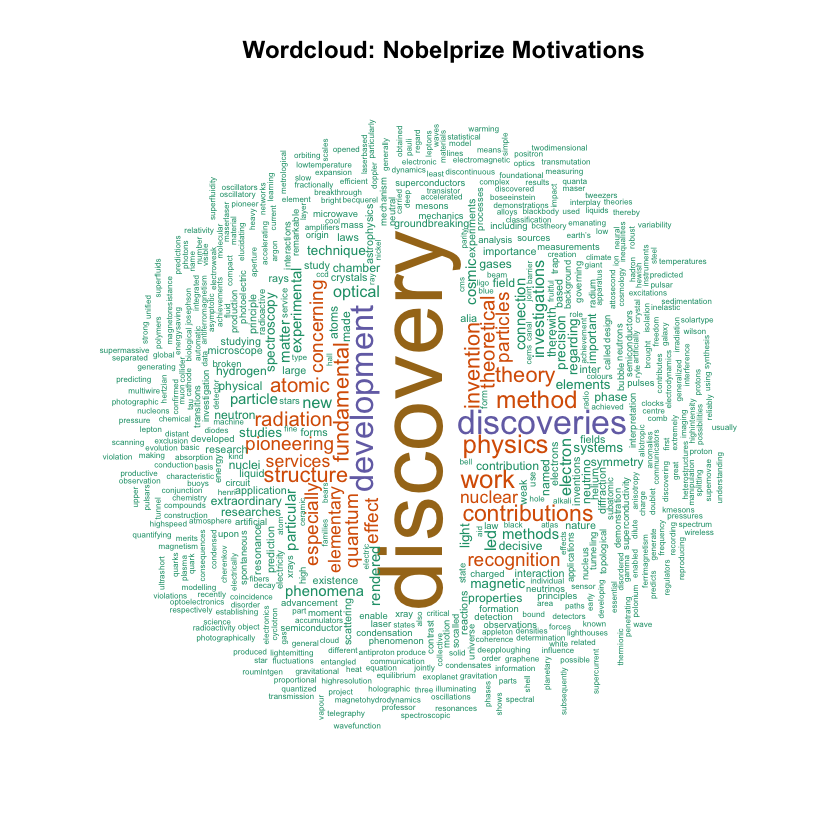

In [88]:
#polish the text
mooncloud <- Corpus(VectorSource(motivations))
mooncloud <- tm_map(mooncloud, content_transformer(tolower))
mooncloud <- tm_map(mooncloud, removePunctuation)
mooncloud <- tm_map(mooncloud, removeNumbers)
mooncloud <- tm_map(mooncloud, stripWhitespace)
mooncloud <- tm_map(mooncloud, PlainTextDocument)


#get the text into a dateframe with a word-count
tdm <- TermDocumentMatrix(mooncloud)
word_matrix<- as.matrix(tdm)
word_freqs <- sort(rowSums(word_matrix), decreasing = TRUE)
word_freqs_df <- data.frame(word = names(word_freqs), freq = word_freqs)


#stopwords 
stopwords <- c("i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
               "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
               "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
               "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
               "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
               "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
               "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
               "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
               "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
               "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same",
               "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now")


# remove stopword and add 2 to each freq
word_freqs_df <- word_freqs_df %>% 
  filter(!(word %in% stopwords)) %>% 
  mutate(freq = freq + 2)   #words that appears less than 3 time doesn't shown, adding 2 solves that issue

# generate wordcloud
wordcloud(
  words = word_freqs_df$word,     
  freq = word_freqs_df$freq,     
  scale = c(4.5, 0.2),               
  max.words = Inf,               
  random.order = FALSE,         
  rot.per = 0.5,
  colors = brewer.pal(7, "Dark2"))
title(main = "Wordcloud: Nobelprize Motivations", col.main = "black")